In [9]:
import logging
import os
from sacred import Experiment
import numpy as np
import seml
from tensorboard import program

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision.utils import save_image

from losses.losses import *
from utils.utils import *
from utils.memory import MemoryBank
from datasets.datasets import SegmentationDataSet, PIRLDataSet, PIRLDataSet2
from datasets.data_constants import *
from models.classifier import FCClassifier, FCClassifierBatchNorm

import importlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# data params
source_dir = '/nfs/students/mirlas/data/'
target_dir = '/nfs/students/mirlas/data/'

snapshots_dir = '/nfs/students/mirlas/snapshots/seg_pirl2_small/'
log_dir = '/nfs/students/mirlas/logdir/seg_pirl2_small/'
pred_dir = '/nfs/students/mirlas/predictions/seg_pirl2_small/'
visualizations_dir = '/nfs/students/mirlas/vizualizations/seg_pirl2_small/'
load_checkpoint = '/nfs/students/mirlas/snapshots/seg/resnet50_fcn_400x800_IN_ce_gamma0.0e+00_lr2.5e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_10.pth'

source_train_images = 'gta5_images_train.txt'
source_train_labels = 'gta5_labels_train.txt'
source_val_images = 'gta5_images_val.txt'
source_val_labels = 'gta5_labels_val.txt'
target_train_images = 'cityscapes_images_train.txt'
target_train_labels = 'cityscapes_labels_train.txt'
target_val_images = 'cityscapes_images_val.txt'
target_val_labels = 'cityscapes_labels_val.txt' 

train_batch_size = 2
val_batch_size = 2
image_height = 400
image_width = 800
grid_size = [2, 4]
num_workers = 8

# network params
backbone = 'resnet50'
classification_head = 'fcn'
pretrained_backbone = True
segmentation_loss = 'focal'
gamma = 2.0
temperature = 0.7
proj_size = 64
memory_bank_device = 'cpu'
memory_bank_size = 2048
memory_bank_batch_size = 2048
aux_injection_point = 'feature'
lambda_aux = 1e-3

# optim params
learning_rate = 2.5e-4
momentum = 0.9
weight_decay = 0.0005
lrs_power = 0.9
learning_rate_aux = 1e-4
betas_aux = [0.9, 0.99]

# training loop params
max_iter = 4000000000
batches_to_eval_train = 1
batches_to_visualize = 1
points_to_sample = 50
save_step = 1
display_step = 1
seed = 42

In [4]:
logger = logging.getLogger()
logger.handlers = []
ch = logging.StreamHandler()
formatter = logging.Formatter(
        fmt='%(asctime)s (%(levelname)s): %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel('INFO')

In [5]:
#  initialize the global parameters
cuda_status = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_status else "cpu")
image_size = (image_height, image_width)
memory_bank_device = torch.device("cpu")
model_name = '_'.join(
        [backbone,
        classification_head,
        str(image_height) + 'x' + str(image_width),
        'grid' + str(grid_size[0]) + 'x' + str(grid_size[1]), 
        ('IN' if pretrained_backbone else ''),
        segmentation_loss,
        aux_injection_point,
        't{:.1e}_proj{}_mbsize{}_mbbatch{}'.format(
        temperature, proj_size, memory_bank_size, memory_bank_batch_size), 
        'gamma{:.1e}_lmbdaux{:.1e}_lr{:.1e}_lraux{:.1e}_m{:.1e}_wd{:.1e}_lrsp{:.1e}'.format(
            gamma, lambda_aux, learning_rate, learning_rate_aux, momentum, weight_decay, lrs_power)
        ])
start_epoch = 0
src_label = 1.
tar_label = 0.
if seed > 0:
    torch.manual_seed(seed)

In [6]:
model_name

'resnet50_fcn_400x800_grid2x4_IN_focal_feature_t7.0e-01_proj64_mbsize2048_mbbatch2048_gamma2.0e+00_lmbdaux1.0e-03_lr2.5e-04_lraux1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01'

In [7]:
#  create neccessary directories for snapshots and logs
if not os.path.exists(os.path.join(snapshots_dir, model_name)):
    os.makedirs(os.path.join(snapshots_dir, model_name))
if not os.path.exists(os.path.join(log_dir, model_name)):
    os.makedirs(os.path.join(log_dir, model_name))
if not os.path.exists(os.path.join(pred_dir, model_name)):
    os.makedirs(os.path.join(pred_dir, model_name))
if not os.path.exists(os.path.join(visualizations_dir, model_name)):
    os.makedirs(os.path.join(visualizations_dir, model_name))

In [10]:
#  initialize the datasets
source_train_dataset = PIRLDataSet2(root=source_dir, image_list_name=source_train_images, 
                            label_list_name=source_train_labels, size=image_size, grid_size=grid_size,
                            mean=GTA5_MEAN, std=GTA5_STD, label2train=GTA5_LABELS2TRAIN)
source_val_dataset = PIRLDataSet2(root=target_dir, image_list_name=source_val_images, 
                        label_list_name=source_val_labels, size=image_size, grid_size=grid_size,  
                        mean=GTA5_MEAN, std=GTA5_STD, label2train=GTA5_LABELS2TRAIN)
target_train_dataset = PIRLDataSet2(root=target_dir, image_list_name=target_train_images, 
                        label_list_name=target_train_labels, size=image_size, grid_size=grid_size,  
                        mean=CITYSCAPES_MEAN, std=CITYSCAPES_STD, label2train=CITYSCAPES_LABELS2TRAIN)
target_val_dataset = PIRLDataSet2(root=target_dir, image_list_name=target_val_images, 
                        label_list_name=target_val_labels, size=image_size, grid_size=grid_size,  
                        mean=CITYSCAPES_MEAN, std=CITYSCAPES_STD, label2train=CITYSCAPES_LABELS2TRAIN)

In [11]:
source_train_dataloader = DataLoader(source_train_dataset, batch_size=train_batch_size,
                                shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
target_train_dataloader = DataLoader(target_train_dataset, batch_size=train_batch_size,
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
source_val_dataloader = DataLoader(source_val_dataset, batch_size=val_batch_size,
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
target_val_dataloader = DataLoader(target_val_dataset, batch_size=val_batch_size, 
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)

In [12]:
inf_source_train_dataloader = inf_iter(source_train_dataloader)
inf_target_train_dataloader = inf_iter(target_train_dataloader)
inf_source_val_dataloader = inf_iter(source_val_dataloader)
inf_target_val_dataloader = inf_iter(target_val_dataloader)

In [13]:
inf_source_val_dataloader = inf_iter(source_val_dataloader)
inf_target_val_dataloader = inf_iter(target_val_dataloader)
inf_source_train_dataloader = inf_iter(source_train_dataloader)
inf_target_train_dataloader = inf_iter(target_train_dataloader)

In [14]:
_, data = next(inf_source_train_dataloader)
data['name']

['14772.png', '03593.png']

In [15]:
max_epochs = max_iter // len(source_train_dataloader)

In [16]:
print('Source train dataloader length: ', len(source_train_dataloader))
print('Source val dataloader length: ', len(source_val_dataloader))
print('Source val dataloader length: ', len(target_train_dataloader))
print('Target val dataloader length: ', len(target_val_dataloader))

Source train dataloader length:  9986
Source val dataloader length:  2496
Source val dataloader length:  1487
Target val dataloader length:  250


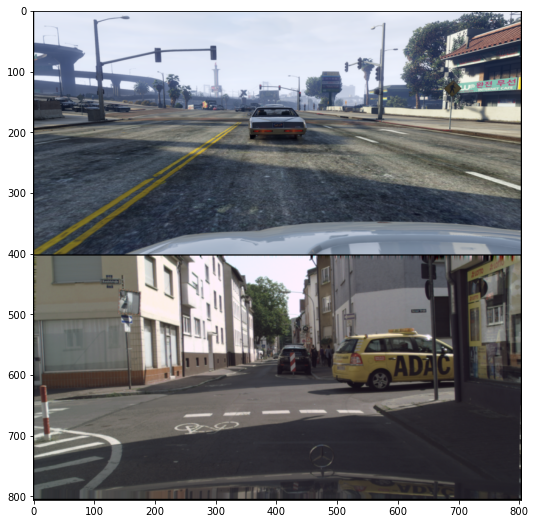

In [17]:
# plot the images
source_sample = source_val_dataset[0]
target_sample = target_val_dataset[0]

grid = make_grid([source_sample['image'], 
                  target_sample['image']],
                nrow=1,
                normalize=True,
                scale_each=True)

plt.imshow(grid.permute(1, 2, 0))

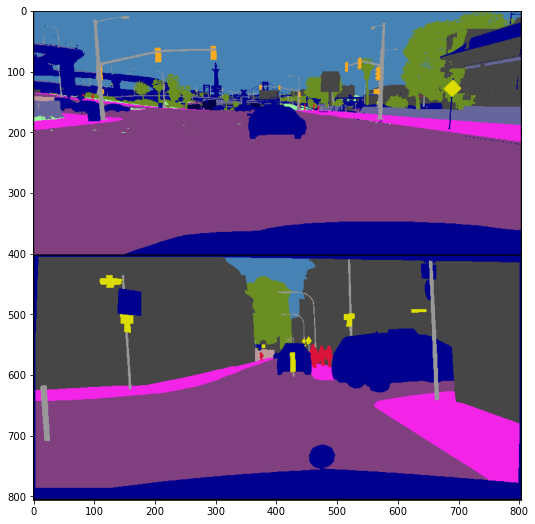

In [18]:
# plot the GTs
source_sample_color_map = create_color_map(source_sample['gt'],
                                          GTA5_LABELS2TRAIN,
                                          GTA5_LABELS2PALETTE)
target_sample_color_map = create_color_map(target_sample['gt'],
                                          CITYSCAPES_LABELS2TRAIN,
                                          CITYSCAPES_LABELS2PALETTE)

grid = make_grid([source_sample_color_map, 
                  target_sample_color_map],
                 nrow=1,
                 normalize=False,
                 scale_each=False)

plt.imshow(grid.permute(1, 2, 0))

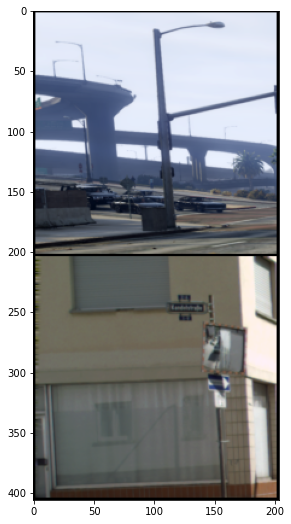

In [24]:
# plot the images
source_sample = source_val_dataset[0]
target_sample = target_val_dataset[0]

# plot the images
grid = make_grid([source_sample['aux_image_real'][0], 
                  target_sample['aux_image_real'][0]],
                nrow=1,
                normalize=True,
                scale_each=True)
plt.imshow(grid.permute(1, 2, 0))

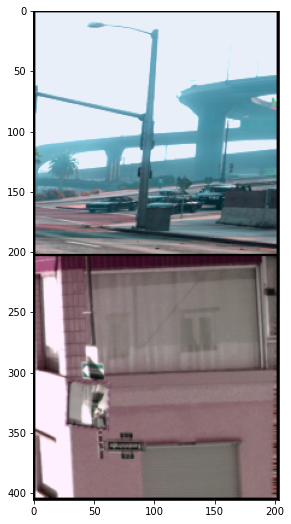

In [25]:
# plot the images
grid = make_grid([source_sample['aux_image_perturbed'][0], 
                  target_sample['aux_image_perturbed'][0]],
                nrow=1,
                normalize=True,
                scale_each=True)
plt.imshow(grid.permute(1, 2, 0))

In [30]:
for i in range(10):
    for j in range(grid_size[0]*grid_size[1]):
        save_image(target_val_dataset[i]['aux_image_real'][j], 
                   os.path.join(visualizations_dir, model_name, 'tar_sample_pirl2_{}_{}.png'.format(i, j)), 
                   normalize=True)
        save_image(target_val_dataset[i]['aux_image_perturbed'][j], 
                   os.path.join(visualizations_dir, model_name, 'tar_sample_pirl2_t_{}_{}.png'.format(i, j)), 
                   normalize=True)
        save_image(target_val_dataset[i]['image'], 
               os.path.join(visualizations_dir, model_name, 'tar_sample_pirl2_i_{}.png'.format(i)), 
               normalize=True)

In [18]:
#  initialize the model and the loss
#  segmentation model
seg_model_name =  classification_head + '_' + backbone
seg_model_loader = getattr(models.segmentation, seg_model_name)
seg_model = seg_model_loader(pretrained=False, 
                num_classes=NUM_CLASSES,
                progress=False,
                aux_loss=False,
                pretrained_backbone=pretrained_backbone)
if segmentation_loss == 'ce':
    seg_loss = torch.nn.CrossEntropyLoss(ignore_index=255)
elif segmentation_loss == 'focal':
    seg_loss = FocalLoss(alpha=1.0, 
                gamma=gamma, 
                ignore_index=255,
                reduction='mean')
else:
    raise ValueError("There are two losses currently supported: [ce, focal]. "
                     "Got: {}".format(segmentation_loss))

In [19]:
#  rotation classifier
if aux_injection_point == 'output':
    classifier_config = {
        'input_dim': NUM_CLASSES,
        'ndf': 64
    }
elif aux_injection_point == 'feature':
    classifier_config = {
        'input_dim': 2048,
        'ndf': 256
    }
else:
    raise ValueError("There are two injection points currently supported: [output, feature]. "
                     "Got: {}".format(aux_injection_point))
classifier_config['num_classes'] = proj_size
classifier_config['avg_pool'] = True
classifier_config['avg_pool_size'] = 1
aux_model = FCClassifierBatchNorm(**classifier_config)
aux_loss = NT_Xent2(temperature, (train_batch_size * grid_size[0] * grid_size[1]) // 2)

In [20]:
memory_bank = MemoryBank(memory_bank_size, memory_bank_batch_size, proj_size, memory_bank_device)

In [21]:
#  initialize the optimizers 
#  we use different lrs for the classifier and the backbone if the latter one is pretrained
optimizer = torch.optim.SGD([{'params': seg_model.backbone.parameters(), 
                              'lr':learning_rate},
                             {'params': seg_model.classifier.parameters(), 
                              'lr':learning_rate * (10 if pretrained_backbone else 1)}],
                            lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer.zero_grad()
aux_optimizer = torch.optim.Adam(aux_model.parameters(),
                        lr=learning_rate_aux, betas=betas_aux)
aux_optimizer.zero_grad()

In [22]:
#  initialize the learning rate scheduler
# lr_poly = lambda epoch: (1 - epoch / max_epochs) ** lrs_power
lr_poly = lambda epoch: 1 ** lrs_power
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_poly, last_epoch=-1)
aux_scheduler = torch.optim.lr_scheduler.LambdaLR(aux_optimizer, lr_lambda=lr_poly, last_epoch=-1)

In [23]:
#  reinitialize if nesseccary
if os.path.isfile(load_checkpoint):
    logging.info('Loading the checkpoint')
    checkpoint = torch.load(load_checkpoint)
    if 'seg_model' in checkpoint:
        seg_model.load_state_dict(checkpoint['seg_model'])
    if 'aux_model' in checkpoint:
        aux_model.load_state_dict(checkpoint['aux_model'])
    if 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])
    if 'aux_optimizer' in checkpoint:
        aux_optimizer.load_state_dict(checkpoint['aux_optimizer'])
    if 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])
    if 'aux_scheduler' in checkpoint:
        aux_scheduler.load_state_dict(checkpoint['aux_scheduler'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1

2020-10-27 15:04:34 (INFO): Loading the checkpoint
/nfs/homedirs/mirlas/anaconda3/envs/ssda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [24]:
start_epoch

10

In [25]:
#  move everything to a device
transfer_model_and_optimizer(seg_model, optimizer, device)
transfer_model_and_optimizer(aux_model, aux_optimizer, device)

In [26]:
aux_model

FCClassifierBatchNorm(
  (main): Sequential(
    (0): Conv2d(2048, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (reduce_dim): AdaptiveAvgPool2d(output_size=1)
  (classifier): Conv2d(2048, 64, kernel_size=(1, 1), stri

In [27]:
#  initialize the SummaryWriter
summary_path = os.path.join(log_dir, model_name)
writer = SummaryWriter(log_dir=summary_path)

In [28]:
#  initialize loss, accuracy values
running_src_seg_loss = 0.0
running_tar_aux_loss = 0.0
running_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, device=device)

In [29]:
seg_model.train()
aux_model.train()

FCClassifierBatchNorm(
  (main): Sequential(
    (0): Conv2d(2048, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (reduce_dim): AdaptiveAvgPool2d(output_size=1)
  (classifier): Conv2d(2048, 64, kernel_size=(1, 1), stri

In [30]:
epoch = 0
batch_idx = 0
for num_iter in range(start_epoch*len(source_train_dataloader), 
                      max_epochs*len(source_train_dataloader)):
    if num_iter % len(source_train_dataloader) == 0:
        epoch = num_iter // len(source_train_dataloader)
        logging.info(f'Epoch: {epoch}/{max_epochs}')
    batch_idx = num_iter % len(source_train_dataloader)

    #  zero the parameter gradients
    optimizer.zero_grad()
    aux_optimizer.zero_grad()

    #  forward pass TARGET image
    #  load target data
    _, data = next(inf_target_train_dataloader)
    aux_image_real, aux_image_perturbed, name = data['aux_image_real'], data['aux_image_perturbed'], data['name']
    aux_image = torch.cat([aux_image_real, aux_image_perturbed]).to(device)
    idxs = get_randperm(train_batch_size * grid_size[0] * grid_size[1], 
                (train_batch_size * grid_size[0] * grid_size[1]) // 2)
    idxs = torch.cat([idxs, idxs + train_batch_size * grid_size[0] * grid_size[1]])
    print(idxs.size())
    aux_image = torch.cat(list(aux_image))[idxs]
    print(aux_image.size())
    
    #  forward pass encoder + segmentation
    features = seg_model.backbone(aux_image)
    output = seg_model.classifier(features['out'])
    output = F.interpolate(output, aux_image.shape[-2:], 
                mode='bilinear', align_corners=False)

    if aux_injection_point == 'output':
        aux_output = aux_model(output)
    else:
        aux_output = aux_model(features['out'])
    aux_output.squeeze_()
    print(aux_output.size())
    
    # sample batch of negative samples from the memory bank
    negative_batch = memory_bank.sample_batch()
    
    if negative_batch is not None:
        print(negative_batch.size())
        #  backprop aux_model
        tar_aux_loss = lambda_aux * aux_loss(aux_output, negative_batch.to(device))
        tar_aux_loss.backward()
    
    # dump image features in the memory bank
    memory_bank.update(aux_output.detach())
    
    #  forward pass SOURCE image
    #  load source data
    _, data = next(inf_source_train_dataloader)
    image, gt, name = data['image'], data['gt'], data['name']
    image = image.to(device)
    gt = gt.to(device)

    #  forward pass encoder + segmentation
    features = seg_model.backbone(image)
    output = seg_model.classifier(features['out'])
    output = F.interpolate(output, image_size, 
                mode='bilinear', align_corners=False)

    #  backprop encoder + segmentation
    src_seg_loss = seg_loss(output, gt)
    src_seg_loss.backward()

    optimizer.step()
    aux_optimizer.step()

    #  update metrics
    with torch.no_grad():
        running_src_seg_loss += src_seg_loss.item()
        running_tar_aux_loss += tar_aux_loss.item() if negative_batch is not None else 0.0
        src_seg_pred = output.argmax(1)
        running_cm += fast_hist(src_seg_pred, gt, NUM_CLASSES)

    #  update the training summary stats: metrics and images
    if (batch_idx + 1) % display_step == 0:
        with torch.no_grad():
            #  train
            pixel_train_acc = pixel_acc(running_cm)
            classwise_train_iou = per_class_iou(running_cm)

            #  val
            src_val_metrics = evaluate_segmentation_set(inf_source_val_dataloader, batches_to_eval_train, 
                seg_model, seg_loss, NUM_CLASSES, device)
            tar_val_metrics = evaluate_segmentation_set(inf_target_val_dataloader, batches_to_eval_train, 
                seg_model, seg_loss, NUM_CLASSES, device)

        logging.info('Iteration {}/{}: Loss: {:.4f} | Pixel accuracy: {:.4f}'.format(batch_idx+1, 
                                                                              len(source_train_dataloader), 
                                                                              src_seg_loss.item(), 
                                                                              pixel_train_acc))

        #  write summary
        writer.add_scalars('Seg_loss', 
            {'training_src_seg_loss': running_src_seg_loss/display_step,
             'validation_src_seg_loss': src_val_metrics['loss'],
             'validation_tar_seg_loss': tar_val_metrics['loss']},
            num_iter)
        writer.add_scalars('Aux_loss', 
            {'training_tar_fake_loss': running_tar_aux_loss/lambda_aux/display_step},
            num_iter)
        writer.add_scalars('Pixel_iou',
            {'training_src_pixel_acc': pixel_train_acc,
             'validation_src_pixel_acc': src_val_metrics['pixel_accuracy'],
             'validation_target_pixel_acc': tar_val_metrics['pixel_accuracy']},
            num_iter)
        for i in range(NUM_CLASSES):
            writer.add_scalar('Class_iou/{}'.format(CLASSES[i]),
                classwise_train_iou[i] if not classwise_train_iou[i] == float('nan') else 0.0,
                num_iter)

        #  reset loss, accuracy values
        running_src_seg_loss = 0.0
        running_tar_aux_loss = 0.0
        running_cm.fill_(0.0)

    #  write images to the summary (twice per epoch)
    if (epoch + 1) % 50 == 0:
#     if (batch_idx + 1) == len(source_train_dataloader) or \
#         (batch_idx + 1) == len(source_train_dataloader) // 2 or \
#         (batch_idx + 1) == len(source_train_dataloader) // 4 or \
#         (batch_idx + 1) == 3 * len(source_train_dataloader) // 4:
        logging.info('Writing summary images')
        with torch.no_grad():
            #  train
            for i in range(len(image)):
                train_src_summary_image = compile_summary_image(image[i], output[i], gt[i], 
                    GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, GTA5_LABELS2PALETTE, scale_factor=0.5)
                writer.add_image('Train/Src',
                    img_tensor=train_src_summary_image, 
                    global_step=num_iter+i, 
                    walltime=None, 
                    dataformats='CHW')
            #  val
            write_summary_images(writer, inf_source_val_dataloader, 
                GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, GTA5_LABELS2PALETTE, 
                seg_model, device, 
                num_batches=1, tag='Val/Src', scale_factor=0.5, global_step=num_iter)
            write_summary_images(writer, inf_target_val_dataloader, 
                CITYSCAPES_MEAN, CITYSCAPES_STD, CITYSCAPES_LABELS2TRAIN, CITYSCAPES_LABELS2PALETTE, 
                seg_model, device, 
                num_batches=1, tag='Val/Tar', scale_factor=0.5, global_step=num_iter)

    #  end_of_epoch
    if (num_iter + 1) % len(source_train_dataloader) == 0:
        #  decay lr
        logging.info('LR update')
        scheduler.step()

#         #  save the model    
#         if (epoch + 1) % save_step == 0:
#             print('Save the model')
#             save_path = os.path.join(snapshots_dir, model_name, 'checkpoint_{}.pth'.format(epoch+1))
#             torch.save({
#                 'seg_model': seg_model.state_dict(),
#                 'aux_model': aux_model.state_dict(),
#                 'optimizer': optimizer.state_dict(),
#                 'aux_optimizer': aux_optimizer.state_dict(),
#                 'scheduler': scheduler.state_dict(),
#                 'aux_scheduler': aux_scheduler.state_dict(),
#                 'epoch': epoch}, save_path)

2020-10-27 15:04:42 (INFO): Epoch: 10/400560


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])


2020-10-27 15:04:48 (INFO): Iteration 1/9986: Loss: 0.0730 | Pixel accuracy: 0.9524


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([16, 64])


2020-10-27 15:04:51 (INFO): Iteration 2/9986: Loss: 0.0845 | Pixel accuracy: 0.9435


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([32, 64])


2020-10-27 15:04:52 (INFO): Iteration 3/9986: Loss: 0.0940 | Pixel accuracy: 0.9512


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([48, 64])


2020-10-27 15:04:54 (INFO): Iteration 4/9986: Loss: 0.0584 | Pixel accuracy: 0.9561


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([64, 64])


2020-10-27 15:04:56 (INFO): Iteration 5/9986: Loss: 0.0621 | Pixel accuracy: 0.9598


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([80, 64])


2020-10-27 15:04:58 (INFO): Iteration 6/9986: Loss: 0.1166 | Pixel accuracy: 0.9443


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([96, 64])


2020-10-27 15:05:00 (INFO): Iteration 7/9986: Loss: 0.2705 | Pixel accuracy: 0.8632


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([112, 64])


2020-10-27 15:05:01 (INFO): Iteration 8/9986: Loss: 0.0794 | Pixel accuracy: 0.9499


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([128, 64])


2020-10-27 15:05:03 (INFO): Iteration 9/9986: Loss: 0.0661 | Pixel accuracy: 0.9511


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([144, 64])


2020-10-27 15:05:05 (INFO): Iteration 10/9986: Loss: 0.1220 | Pixel accuracy: 0.9191


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([160, 64])


2020-10-27 15:05:07 (INFO): Iteration 11/9986: Loss: 0.0847 | Pixel accuracy: 0.9471


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([176, 64])


2020-10-27 15:05:09 (INFO): Iteration 12/9986: Loss: 0.0914 | Pixel accuracy: 0.9467


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([192, 64])


2020-10-27 15:05:10 (INFO): Iteration 13/9986: Loss: 0.0826 | Pixel accuracy: 0.9416


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([208, 64])


2020-10-27 15:05:12 (INFO): Iteration 14/9986: Loss: 0.0807 | Pixel accuracy: 0.9443


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([224, 64])


2020-10-27 15:05:14 (INFO): Iteration 15/9986: Loss: 0.0919 | Pixel accuracy: 0.9410


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([240, 64])


2020-10-27 15:05:16 (INFO): Iteration 16/9986: Loss: 0.1064 | Pixel accuracy: 0.9315


torch.Size([16])
torch.Size([16, 3, 200, 200])
torch.Size([16, 64])
torch.Size([256, 64])


KeyboardInterrupt: 

In [34]:
aux_loss(aux_output, negative_batch.to(device))

In [ ]:
#  evaluate the model
seg_model.eval()
aux_model.eval()
with torch.no_grad():
    src_val_metrics = evaluate_segmentation_set(inf_source_val_dataloader, len(source_val_dataloader), 
        seg_model, seg_loss, NUM_CLASSES, device)
    tar_val_metrics = evaluate_segmentation_set(inf_target_val_dataloader, len(target_val_dataloader), 
        seg_model, seg_loss, NUM_CLASSES, device)
print(src_val_metrics)
print(tar_val_metrics)

In [ ]:
#  write results
results = dict()
results.update({'src_'+k: v for k, v in src_val_metrics.items()})
results.update({'tar_'+k: v for k, v in tar_val_metrics.items()})
print(results)

In [ ]:
predictions_path = os.path.join(pred_dir, model_name)

In [ ]:
predictions_path

In [ ]:
with torch.no_grad():
    write_predictions(source_val_dataloader, seg_model, device, 
            batches_to_visualize, predictions_path, 
            GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, 
            GTA5_LABELS2PALETTE, prefix='src_')

In [ ]:
with torch.no_grad():
    write_predictions(target_val_dataloader, seg_model, device, 
            batches_to_visualize, predictions_path, 
            CITYSCAPES_MEAN, CITYSCAPES_STD, CITYSCAPES_LABELS2TRAIN,
            CITYSCAPES_LABELS2PALETTE, prefix='tar_')

In [ ]:
with torch.no_grad():
    create_embeddings(writer, inf_source_val_dataloader, inf_target_val_dataloader, 
            seg_model, device, 
            batches_to_visualize, points_to_sample)